# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import scipy.optimize as opt
%matplotlib widget

# Inputs

In [2]:
data_file = "Data/Trapped Particle 02 - 2M pts.CSV"
nperseg = 2**15 # Used for scipy.signal.welch PSD calculation
r_pix = 23 # pixels
T = 297 # Kelvin
eta = 0.00089 # Viscosity of water (dependent on temperature)
pix_to_dist = 374.14 # px per div (10 microns)
min_freq, max_freq = 0, 10000 # Min and max frequencies (exclusive) for plotting and calculations after FFT

# Load and plot data

,TIME,CH1
0,-32.00000,-13.3
1,-31.99997,-13.3
2,-31.99994,-13.3
3,-31.99990,-13.3
4,-31.99987,-13.1
...,...,...
1999995,31.99984,-11.6
1999996,31.99987,-11.7
1999997,31.99990,-11.8
1999998,31.99994,-11.9


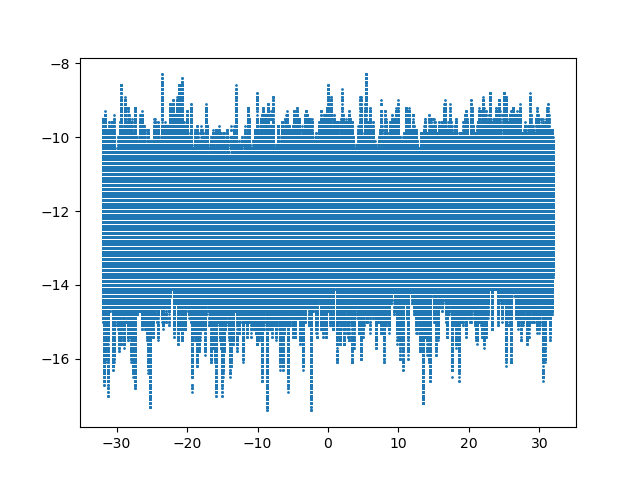

In [3]:
data = pd.read_csv(data_file, skiprows=15)
display(data)

plt.figure()
plt.plot(data['TIME'], data['CH1'], 'o', markersize=1)
plt.show()

# Calculating FFT and PSD

In [4]:
use_welch = True

voltages = data['CH1'] # Extract the signal
voltages = voltages - voltages.mean() # De-mean the signal

dt = data['TIME'].iloc[1] - data['TIME'].iloc[0] # Get the time step between points
total_timesteps = len(voltages) # Get the total number of time steps

if use_welch:
    # Compute PSD using scipy.signal.welch for better performance
    welch = signal.welch(voltages, fs=1/dt, nperseg=nperseg, scaling='density')
    freqs = welch[0]
    psd = welch[1]
else:
    # Compute RFFT, PSD and frequency bins, sort the results by PSD
    fhat = np.fft.rfft(voltages, total_timesteps)
    psd = fhat * np.conj(fhat) / (total_timesteps * dt)
    # Adjust the PSD for the symmetry of the RFFT
    psd *= 2

    # Frequency bins for the RFFT
    freqs = np.fft.rfftfreq(total_timesteps, d=dt)

    # Verify that PSD is real
    assert np.allclose(psd, psd.real)
    psd = psd.real

psds = pd.DataFrame({'Frequency': freqs, 'PSD': psd})

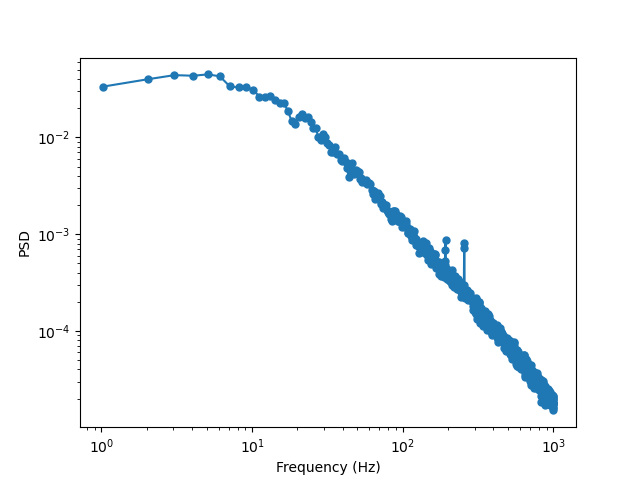

In [5]:
mask = psds['Frequency'] > 0 # Ignore the zero frequency
mask &= psds['Frequency'] < 1000 # Ignore high frequency noise

# We use a scatter plot with a connecting line
plt.figure()
plt.plot(psds['Frequency'][mask], psds['PSD'][mask] , 'o-', markersize=5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.xscale('log')
plt.yscale('log')

plt.show()

# Lorentzian fitting to PSD

Optimal Gamma: 97.29539892931672
Optimal f0: 1.537083560067437
Optimal x2: 0.3188470538178539


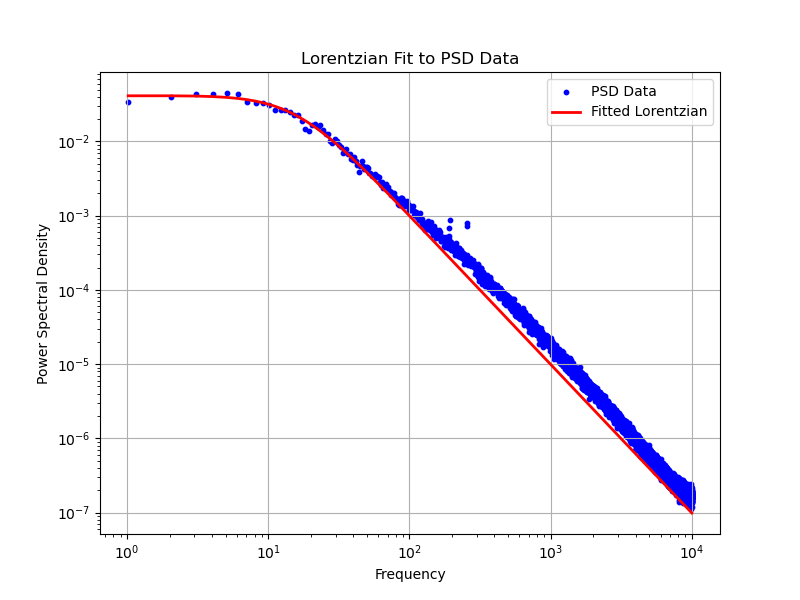

In [6]:
x_squared_expectation = np.mean((data['CH1'] - data['CH1'].mean())**2)

mask = psds['Frequency'] > min_freq # Ignore the zero frequency
mask &= psds['Frequency'] < max_freq # Ignore high frequency noise

# Define the Lorentzian function with f0 and gamma as parameters
def lorentzian(f, gamma, f0, x2):
    return (2 * x2 * (gamma / (2 * np.pi))) / ((f - f0)**2 + (gamma / (2 * np.pi))**2)

# Initial guesses for Gamma and f0
initial_guess = [30.0, -10.0, x_squared_expectation]  # [gamma, f0]

# Fit the Lorentzian function to PSD data
popt, _ = opt.curve_fit(
    lambda f, gamma, f0, x2: lorentzian(f, gamma, f0, x2),
    freqs[mask],
    psd[mask],
    p0=initial_guess
)

# Extract optimal parameters
gamma_opt, f0_opt, x2_opt = popt
print(f"Optimal Gamma: {gamma_opt}")
print(f"Optimal f0: {f0_opt}")
print(f"Optimal x2: {x2_opt}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(freqs[mask], psd[mask], label="PSD Data", color="blue", s=10)
plt.plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)
plt.title("Lorentzian Fit to PSD Data")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.show()

# Rho calculation

In [7]:
kb = 1.380649e-23 # SI units
r = r_pix / pix_to_dist * 1e-5 # Convert radius to meters

# S is psd, f is frequency
def rho(S, f):
    return np.sqrt(6 * np.pi**3 * eta * f**2 * S * r / kb / T)

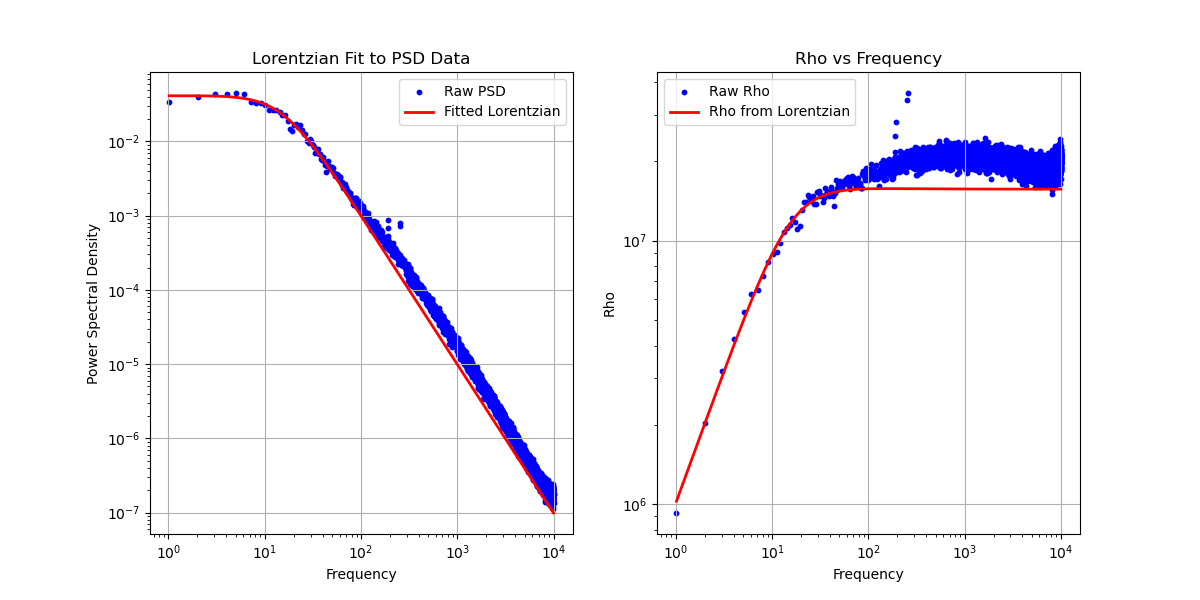

In [8]:
plt.figure(figsize=(12, 6))

# Plot the Lorentzian fit to the PSD data
plt.subplot(1, 2, 1)
plt.scatter(freqs[mask], psd[mask], label="Raw PSD", color="blue", s=10)
plt.plot(freqs[mask], lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), label="Fitted Lorentzian", color="red", lw=2)
plt.title("Lorentzian Fit to PSD Data")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)

# Plot rho vs frequency
plt.subplot(1, 2, 2)
plt.scatter(freqs[mask], rho(psd[mask], freqs[mask]), label="Raw Rho", color="blue", s=10)
plt.plot(freqs[mask], rho(lorentzian(freqs[mask], gamma_opt, f0_opt, x2_opt), freqs[mask]), label="Rho from Lorentzian", color="red", lw=2)
plt.title("Rho vs Frequency")
plt.xlabel("Frequency")
plt.ylabel("Rho")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.show()

# Pick rho

In [17]:
rho = 20.1e7 # Select a rho value

# Calculate diffusion constant

In [ ]:
rho = 2.1e7 # Select a rho value

data['x'] = data['CH1'] / rho
data['x'] = data['x'] - data['x'].mean() # Center the data
x_squared_expectation = (data['x']**2).mean() # Meters squared
print(x_squared_expectation)

k = kb * T / x_squared_expectation # Spring constant
zeta = 6 * np.pi * eta * r # Mobility
gamma = k / zeta # Characteristic relaxation rate
D = gamma * x_squared_expectation # Diffusion coefficient
print("Diffusion coefficient: ", np.round(D, 17))

2.8956750077591126e-17
Diffusion coefficient:  3.9761e-13


In [ ]:
# NOTE: This is the simplified version of the D formula in the cell above
# It doesn't really rely on the data we take (other than basic stuff like T and r)
# TODO: we should make sure we're actually using a formula for which rho doesn't cancel out
D = kb * T / (6 * np.pi * eta * r)